In [1]:
# --- Standard libraries
import os
import copy
import re
import json
import codecs
import numpy as np
import pandas as pd
from tqdm import tqdm
from natsort import natsorted
from scipy.signal import find_peaks
# --- Matplotlib
import matplotlib.pyplot as plt
# --- ASE
from ase.io import read
# --- RDKit
import rdkit
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolFromXYZFile
from rdkit.Chem import rdDetermineBonds
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices=True
IPythonConsole.drawOptions.annotationFontScale=0.8
IPythonConsole.molSize = 400,400
from dataset import XASDataset_mol
rdkit.__version__

'2024.03.5'

### Code functions

In [2]:
def get_xyz_file(directory):
    '''
    
    '''
    # --- Get a list of all the files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    # --- Pattern to find the xyz file
    pattern = r'OPT_[\w]+\.xyz$'

    for file in files:
        if re.match(pattern, file):
            xyz_name = file
            break

    xyz_path = os.path.join(directory, xyz_name)
    return xyz_path

def rearrange_xyz(file_path):

    '''
    Function that rearranges the given .xyz file to move all the
    oxygen and hydrogen atoms to the bottom of the file
    '''

    # --- Open the original .xyz file and parse the lines with
    # --- O and H coordinates to lists
    with open(file_path, 'r') as fr:
        lines = fr.readlines()
        o_lines = []
        h_lines = []

        for line in lines:
            if line.startswith('  O'):
                o_lines.append(line)
            elif line.startswith('  H'):
                h_lines.append(line)

        # --- Open the .xyz file to write
        with open(file_path, 'w') as fw:

            # --- Write all lines that are not O or H coordinates
            for line in lines:
                if line.startswith('  H'):
                    pass
                elif line.startswith('  O'):
                    pass
                else:
                    fw.write(line)
        
            # --- Write O coordinates
            for x in o_lines:
                fw.write(x)

            # --- Write H coordinates
            for y in h_lines:
                fw.write(y)

def create_mol(file_path):
    '''
    
    '''
    # --- Read in and create RDkit mol variable
    mol = MolFromXYZFile(file_path)
    rdDetermineBonds.DetermineBonds(mol)
    Chem.RemoveStereochemistry(mol)
    
    # --- Get the xyz coordinates of the molecule
    ase_go = read(file_path)
    pos = ase_go.get_positions()

    # --- Create a dictionary of the atom indexing
    xyz_dict = {}
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(atom.GetIdx())
        xyz_dict[atom.GetIdx()] = list(pos[i])

    # --- The atom indexing changes 
    smiles = Chem.MolToSmiles(mol)
    new_mol = Chem.MolFromSmiles(smiles)
    map_num = {}
    for atom in new_mol.GetAtoms():
        map_num[atom.GetAtomMapNum()] = atom

    # --- Get a ordered list of the atom map numbers
    sort_map = sorted(map_num)

    idx_dict = {}
    for num in sort_map:
        if map_num[num].GetAtomicNum() == 6:
            idx_dict[num] = map_num[num].GetIdx()

    return new_mol, smiles, idx_dict

def broaden_spectrum(E, osc):
    '''
    Take the delta peaks of a XAS spectrum and applies
    a Gaussian broadening scheme
    '''

    x = np.linspace(280, 300, num=200, endpoint=True)
    sigma = 0.6
    gE = []

    # --- Apply Gaussian broadening
    for Ei in x:
        tot = 0
        for Ej, os in zip(E, osc):
            tot += os * np.exp(-((((Ej - Ei) / sigma) ** 2)))
            #norm_tot = tot / 6471.923222767645
        gE.append(tot)
    
    return gE

### Start code

In [43]:
# --- Path to main folder where all the data is
data_path = '../../work/data/GO_XAS_data/circumcoronene/OPT_output'
# --- Create a list with the path of all the different molecule folders
subdirs = [os.path.join(data_path, d) for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

# --- Number of molecules in the data set
print(len(subdirs))
# --- List of paths to all the different molecules
print(subdirs)

91
['../../work/data/GO_XAS_data/circumcoronene/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_3_ieEPOXY_0_0', '../../work/data/GO_XAS_data/circumcoronene/OPT_output/cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_1', '../../work/data/GO_XAS_data/circumcoronene/OPT_output/cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_2', '../../work/data/GO_XAS_data/circumcoronene/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_3_iOH_0_iEPOXY_0_ieEPOXY_0_2', '../../work/data/GO_XAS_data/circumcoronene/OPT_output/cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_1_eKETO_3_iOH_0_iEPOXY_0_ieEPOXY_0_2', '../../work/data/GO_XAS_data/circumcoronene/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0', '../../work/data/GO_XAS_data/circumcoronene/OPT_output/cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_0_1', '../../work/data/GO_XAS_data/circumcoronene/OPT_output/cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_e

In [44]:
mol_name = []
# --- Split up into the directory path and list of all the folder/molecule names
for subdir in subdirs:
    dir_path, path = os.path.split(subdir)
    mol_name.append(path)

print(len(mol_name))
# --- List of all the molecule names
print(mol_name)

91
['cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_3_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_1_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_3_iOH_0_iEPOXY_0_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_1_eKETO_3_iOH_0_iEPOXY_0_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_1_eCHO_0_eKETO_0_iOH_3_iEPOXY_1_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_1_eKETO_0_iOH_0_iEPOXY_1_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_1_eKETO_2_iOH_0_iEPOXY_0_ieEPOXY_2_2', 'cir_R_eOH_0_eCOOH__2_eEPOXY_0_eCHO_1_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__1_eEPOXY_0_eCHO_1_eKETO_1_iOH_1_iEPOXY_0_ieEPOXY_0_1', 'cir_R_eOH_1_eCOOH__1_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_1_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_2_1', 'cir_R_eOH_0_eCOOH__1_eEPOXY_1_eCHO_0_eKETO_0_iOH_1_iEPOXY_0_ieEPOXY_2_0', 'cir_R_eOH_0_eCOOH__2

In [45]:
# --- Create python dictionaries
final_dict = {}
mol_dict = {}
smiles_dict = {}

# --- Loop through all the molecule directories
for subdir in tqdm(subdirs):
    dir_path, mol_name = os.path.split(subdir)

    # --- Get 
    xyz_path = get_xyz_file(subdir)
    # --- Rearrage the xyz file 
    rearrange_xyz(xyz_path)
    # ---
    mol, smiles, id_dict = create_mol(xyz_path)

    # --- Get all the individual atom directories for molecule
    atom_direcs = [os.path.join(subdir, d) for d in os.listdir(subdir) if os.path.isdir(os.path.join(subdir, d))]
    # --- Sort directories in numerical order
    sorted_direcs = natsorted(atom_direcs)
    spec_dict = {}

    # ---
    for i in range(len(sorted_direcs)):
        atom_dir = sorted_direcs[i]
        # --- Get a list of all the files in the directory
        atom_files = [f for f in os.listdir(atom_dir) if os.path.isfile(os.path.join(atom_dir, f))]

        # ---
        for file in atom_files:
            if file.endswith('abs.stk'):
                spec_df = pd.read_csv(os.path.join(atom_dir, file), sep='\s+', header=None,
                                      names=['Peaks', 'Strength'])
                # --- Extract the photon energy and oscilator strength
                energies, osc = spec_df['Peaks'], spec_df['Strength']
                # --- Broaden the spectra
                gE = broaden_spectrum(energies, osc)

                # --- Shift the peaks to the same start point
                # max_val = find_peaks(gE)
                # begin = max_val[0][0] - 15
                # end = max_val[0][0] + 185
                # gE = gE[begin:end]
                # top = max(gE)
                # if top > maxx:
                #     maxx = top
                
                # --- Normalise the spectra to 1
                # --- coronene
                # norm_spec = [1.0 * (e / 6471.923222767645) for e in gE]
                # --- circumcoronene
                norm_spec = [1.0 * (e / 6924.662753770557) for e in gE]

                # --- Save as xyz file indexing
                # xyz_idx = list(id_dict.keys())[list(id_dict.values()).index(id_dict[i])]
                # spec_dict[xyz_idx] = norm_spec
                # --- Save as rdkit/networkx indexing
                spec_dict[id_dict[i]] = norm_spec
    
    final_dict[mol_name] = spec_dict
    mol_dict[mol_name] = smiles         

    # # --- Call function to create spectrum dictionary
    # mol, spec_list, smiles, pos, z = create_spec_dict(subdir)
    # num_carbons = count_atoms(mol, 6)

    # # --- Sanity check number of carbons in mol matches
    # # --- the number of spectra, if so create dictionaries
    # if len(spec_list.keys()) == num_carbons:
    #     spec_dict[mol_name] = spec_list
    #     mol_dict[mol_name] = smiles, pos.tolist(), z
    # else:
    #     print('Molecule invalid:', subdir)


100%|██████████| 91/91 [02:29<00:00,  1.64s/it]


In [46]:
# Combine the mol and spectra dictionaries into one variable
data = []

data.append(mol_dict)
data.append(final_dict)

In [47]:
# --- Save the data into a json file
json.dump(data, codecs.open('./raw/data_circumcoronene.json', 'w', encoding='utf-8'),
          separators=(',', ':'),
          sort_keys=True,
          indent=4)

### Check saved data

In [2]:
with open('./raw/data_circumcoronene.json', 'r') as j_file:
    data = json.load(j_file)

In [3]:
data[0]

{'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2': 'c12[c:1]3[c:2]4[c:3]([c:4]([H:57])[c:5]1[H:58])=[C:38]([H:71])[C:39]15[C:40]6([c:9]4[c:8]4[c:7]7[c:6]3[c:24]3[c:23]([c:22]2[H:61])[c:31]([H:62])[c:32]([H:63])[c:33]2[c:25]3[c:26]3[c:10]7[c:11]7[c:12]8[c:13]4[c:42]4[c:43]9[c:44]%10[c:17]8[c:16]8[c:15]%11[c:14]7[C:28]7%12[C:27]3([C:35](=[C:34]2[H:64])[C:36]([H:73])=[C:37]([H:74])[C:29]7=[C:30]([H:72])[c:18]%11[c:19]([H:59])[c:20]([H:60])[c:21]8[c:46]([H:65])[c:45]%10[c:53]([H:70])[c:52]([H:69])[c:51]9=[C:50]([H:68])[C:49]2([C:41]64[O:54]2)[C:48]([H:67])=[C:47]1[H:66])[O:55]%12)[O:56]5',
 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_4_ieEPOXY_0_1': 'c12[c:1]3[c:2]4[c:3]([c:4]([H:58])[c:5]1[H:59])[c:38]([H:77])[c:39]1[c:40]5[c:9]4[c:8]4[c:7]6[c:6]3[C:24]37[C:23]([C:22]2([H:62])[H:69])([C:31]([H:63])=[C:32]([H:64])[C:33]2=[C:34]([H:65])[c:35]8[c:27]9[c:28]%10[c:14]%11[c:15]%12[c:18]([c:30]([H:70])[c:29]%10[c:37]([H:67])[c:36]8[H:66])[C:19]([H:60])=[C:

In [4]:
# --- Load all the molecule names from keys of first dictionary
keys = []

for i in data[0].keys():
    keys.append(i)

print(keys)

['cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_3_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_0_iEPOXY_4_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_1_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_3_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_0_ieEPOXY_2_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_2_ieEPOXY_1_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_3_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_0_iEPOXY_3_ieEPOXY_1_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_1_iOH_2_iEPOXY_1_ieEPOXY_0_0', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_2_iOH_0_iEPOXY_0_ieEPOXY_3_1', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_2_iOH_1_iEPOXY_1_ieEPOXY_1_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_2_iOH_1_iEPOXY_2_ieEPOXY_0_2', 'cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_3_iOH_0_iEPOXY_0_ieEPOXY_0_1', 'cir_R_eOH_0_eCOOH__0_eE

In [5]:
# --- View the data stored in the second dictionary for a given key
mol_name = keys[2]
# mol_name = 'R_eOH_0_eCOOH__1_eEPOXY_2_eCHO_0_eKETO_0_iOH_0_iEPOXY_0_ieEPOXY_1_0'

print(mol_name)
print(len(data[1][mol_name].keys()))
print(data[1][mol_name].keys())

cir_R_eOH_0_eCOOH__0_eEPOXY_0_eCHO_0_eKETO_0_iOH_1_iEPOXY_1_ieEPOXY_1_0
54
dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '43', '44', '45', '46', '47', '48', '49', '50', '52', '53', '54', '55'])


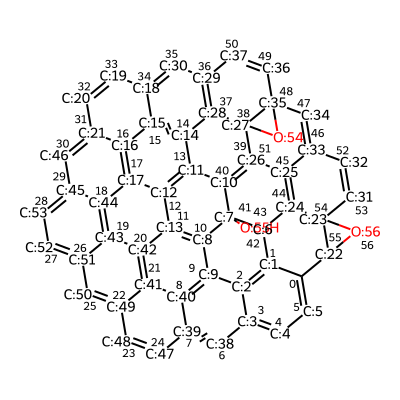

In [6]:
# --- Create RDKit mol from SMILES
mol = Chem.MolFromSmiles(data[0][mol_name])
mol

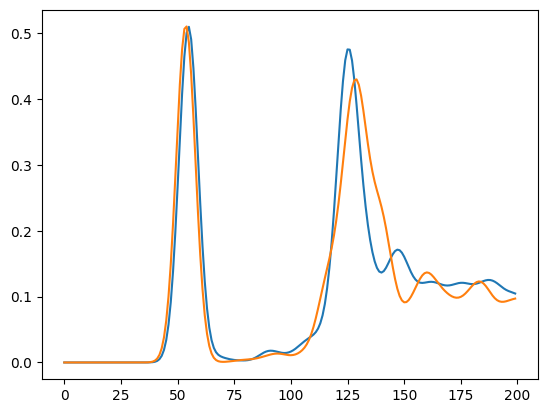

In [7]:
# --- Plot similar spectra of similar chemical environments
# --- to check if dictionary is right
plt.plot(data[1][mol_name]['14'])
plt.plot(data[1][mol_name]['15'])
# plt.plot(data[1][mol_name]['30'])
plt.show()

### Create dataset

In [8]:
path = './'
dataset = XASDataset_mol(path)

/home/samjhall/miniconda3/envs/pyg-schnet/lib/python3.11/site-packages/torch_geometric/data/dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) an

Total number of molecules 91


Done!
/home/samjhall/github/GNN-XAS-GO/dataset.py:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.processed_paths[0])


In [9]:
# --- Save dataset
import torch

torch.save(dataset, './circ_xasnet.pt')